##  Example of how to use Sonobat Guano MD to create tables ready for statistical analysis (Occupancy Modeling)

Written by Colin Talbert 2018-127


#### Between the content that is stored in the Guano MD and the content in the NABat file naming convention, nearly all the info we need is at hand.

In [1]:
from guano import GuanoFile

import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
input_dname = r"F:\CO_NABat\CO 2016 acoustic"
d = Path(input_dname)
excel_fnames = d.glob('**\*.xlsx')

output_dname = r"Z:\TSH\DD274_NABat\CNHP_data_processing\Derived\2016_output"
out_dir = Path(output_dname)

## Some files were missing Consensus recordings

For most of these, there were no recordings that were able to be classified to “Consensus”, so there were no files to manually vet. These efforts are still important to record, however, but they are negative for all species for all 4 nights of survey.

In [3]:
# missing_fnames = [r"F:\CO_NABat\CO 2016 acoustic\221\NABAT221E-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\306\306SE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\562\562NE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\562\562SW-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\786\786NE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\786\786SE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\786\786SW-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\1533\1533SE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\2610\2610SE-BatchClassify.txt",
#               r"F:\CO_NABat\CO 2016 acoustic\2610\2610SW-BatchClassify.txt"]

# for fname in missing_fnames:
#     df = pd.read_csv(fname, sep='\t')
#     df['EVALUATION'] = 0
#     df.to_excel(fname.replace('.txt', '.xlsx'), index=False)

In [4]:
from datetime import datetime, timedelta

def monitoring_night(dt):
    # return the sample night from a date time
    # if after midnight return previous date
    if dt.hour < 12:
        monitoringnight = dt.date() - timedelta(days=1)
    else:
        monitoringnight = dt.date()
        
    return monitoringnight
    

def parse_nabat_fname(fname):
    try:
        """If a file is in the format specified by NABat (grtsid_sitename_date_time.wav)
        parse it and return the components.  

        Allows for some discrepansies an malformations
        """
        fname = fname.replace('-', '_')
        fname = fname.replace('__0__', '_')
        fname = fname.replace('__1__', '_')
        fname = fname.replace('_0+1_', '_')
        fname = fname.replace('___', '_')
        fname = fname.replace('__', '_')

        f = Path(fname)
        
        name = f.stem
        if name.lower().startswith('nabat'):
            name = name[5:]
        if name.startswith('_'):
            name = name [1:]
        if name.startswith('Q'):
            name = name [1:]
            
        if len(name.split('_'))==2:
            name = f"{f.parent.name}_{name}"

        digit = name[0]
        grtsid = ''
        while digit.isnumeric():
            name = name [1:]
            grtsid += digit
            digit = name[0]

        if name.startswith('_'):
            name = name [1:]
        try:
            sitename, datestr, timestr = name.split('_')
        except:
            print(fname, "name.split failed")
        
        if len(timestr) > 6:
            print(f"problem time: {timestr}, {fname}")
            timestr = "000000"
        dt = datetime.strptime('T'.join([datestr, timestr]), "%Y%m%dT%H%M%S")


        return(grtsid, sitename, dt, monitoring_night(dt))
    except Exception as e:
        print(e, fname)
        raise Exception

In [5]:
def excel_to_df(fname):
#     print(fname)
    df = pd.read_excel(fname).rename(columns=lambda x: x.strip().replace(' ', ''))
    
    
    df['GridCellID'], df['SiteID'], df['filedatetime'], df['monitoringnight'] = zip(*df.Path.apply(parse_nabat_fname))

        

    df = df.rename(columns={"Consensus": "Species_Auto_ID", "EVALUATION": "Species_Manual_ID"})
#     print(df.columns)
    
    df['Species_Manual_ID'] = df['Species_Manual_ID'].astype(str).str.upper().str.strip()
    df['Species_Auto_ID'] = df['Species_Auto_ID'].astype(str).str.upper().str.strip()

    ambiguous = df.Species_Manual_ID.str.startswith('UNCONFIRM', na=False)
    df.loc[ambiguous, 'Species_Manual_ID'] = 'UNCONFIRMED'
    
    return df

In [6]:
dfs = []
errors = []

for excel_fname in excel_fnames:
    try:
        dfs.append(excel_to_df(excel_fname))
    except Exception as e:
        errors.append(excel_fname)
        print(excel_fname, e)
    
df = pd.concat(dfs)
df = df.rename(columns={"Path":"path",
                   "Filename":"filename"})

F:\CO_NABat\CO 2016 acoustic\221\~$NABAT221E-BatchClassify.xlsx Unsupported format, or corrupt file: Expected BOF record; found b'\x0eTalbert'
F:\CO_NABat\CO 2016 acoustic\221\BLM SonoBat analysis\NABAT221E Data.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\221\BLM SonoBat analysis\NABAT221NE Data.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\221\BLM SonoBat analysis\NABAT221NE-2 Data.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\2717\BLM classifications\NABAT2717NW-BatchData1.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\2717\BLM classifications\NABAT2717SE-BatchData1.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\2717\BLM classifications\NABAT2717SW-BatchData1.xlsx 'DataFrame' object has no attribute 'Path'
F:\CO_NABat\CO 2016 acoustic\701\701NE_SonoBatch_v420.xlsx 'Species_Manual_ID'


C:\Anaconda3\envs\pyviz\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [7]:
# %%time

# rows = []
# mds = []

# problems = []

# for wav in wavs:
#     try:
#         g = GuanoFile(str(wav))
#         md = dict(g.items())
#         md['filepath'] = wav.parent
#         md['filename'] = wav.name
#         md['seconds'] = g.wav_params.nframes / g.wav_params.framerate
#         mds.append(md)
#     except: 
#         print(str(wav))
#         problems.append(str(wav))


### This gives us a dataframe of the Guano MD in that folder

In [8]:
# df = pd.DataFrame(mds).set_index('Timestamp')
# df.columns = [col.replace('|', '_').replace(' ', '_') for col in df.columns]
# df['Species_Manual_ID'][df.Species_Manual_ID==''] = 'Not Vetted'
# df['Species_Manual_ID'] = df['Species_Manual_ID'].str.upper()
# df['Species_Auto_ID'] = df['Species_Auto_ID'].str.upper()
# df.head(10)

#### Not True!  We're currently only moving up the records for which we got a manual vetting confirmation of the autoid species

In [29]:
ambiguous = df.Species_Manual_ID.str.startswith('UNCONFI', na=False)
df.loc[ambiguous, 'Species_Manual_ID'] = 'UNCONFIRMED'

ambiguous = df.Species_Manual_ID.str.startswith('UNCOMFIRM', na=False)
df.loc[ambiguous, 'Species_Manual_ID'] = 'UNCONFIRMED'

ambiguous = df.Species_Manual_ID.str.startswith('UNSURE', na=False)
df.loc[ambiguous, 'Species_Manual_ID'] = 'UNCONFIRMED'

ambiguous = df.Species_Manual_ID.str.startswith('0', na=False)
df.loc[ambiguous, 'Species_Manual_ID'] = 'UNCONFIRMED'

df.Species_Manual_ID.unique()

array(['NAN', 'LANO', 'MYCI', 'TABR', 'UNCONFIRMED', 'MYLU', 'LACI',
       'MYEV', 'MYVO', 'EPFU', 'LABO', 'MYTH', 'PAHE', 'ANPA', 'COTO',
       'MYYU', 'EUMA', 'MYCA'], dtype=object)

In [30]:
df.to_csv(out_dir.joinpath("raw_data.csv"))

In [10]:
confirmed = df[~df.Species_Manual_ID.isin(['NOT VETTED', 'UNCONFIRMED', 'NOISE', 'UNIDENTIFIED', 'YES', 'NAN', '0'])].dropna(subset=['Species_Manual_ID'])
confirmed.head()

,#Accpt,#Maj,1st,2nd,3rd,4th,<--AllsppinsqncclassifiedwithaDP>0.75inorderofprevalence,AccpQualForTally,AccpQuality,ByVote,...,ParentDir,path,Preemphasis,SiteID,Species_Auto_ID,Species_Manual_ID,Version,calls/sec,filedatetime,monitoringnight
4,5.0,5.0,Lano,NaN,NaN,NaN,NaN,0.2,0.8,Lano,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,LANO,LANO,3.15,2.16,2016-07-22 21:42:12,2016-07-22
7,3.0,3.0,Myci,NaN,NaN,NaN,NaN,0.2,0.8,Myci,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,MYCI,MYCI,3.15,8.41,2016-07-22 21:47:13,2016-07-22
8,2.0,2.0,Tabr,NaN,NaN,NaN,NaN,0.2,0.8,Tabr,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,TABR,TABR,3.15,1.91,2016-07-22 21:52:03,2016-07-22
34,5.0,5.0,Mylu,NaN,NaN,NaN,NaN,0.2,0.8,Mylu,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,MYLU,MYLU,3.15,7.83,2016-07-22 22:57:28,2016-07-22
78,1.0,1.0,Laci,NaN,NaN,NaN,NaN,0.2,0.8,Laci,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,LACI,LACI,3.15,3.86,2016-07-23 03:07:30,2016-07-22


## A quick plot of the classification results

##### The code to plot a confusion matrix was pulled from [a user contributed Kaggle notebook], and is hidden in the cell below.
[a user contributed Kaggle notebook]: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

In [11]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Manual vs Auto ID',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure()
    
    mcm = np.ma.MaskedArray(cm)
    mcm.mask = cm==0

    plt.imshow(mcm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "darkslategray")


    plt.tight_layout()
    plt.ylabel('Manual Species label')
    plt.xlabel('Auto Species label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

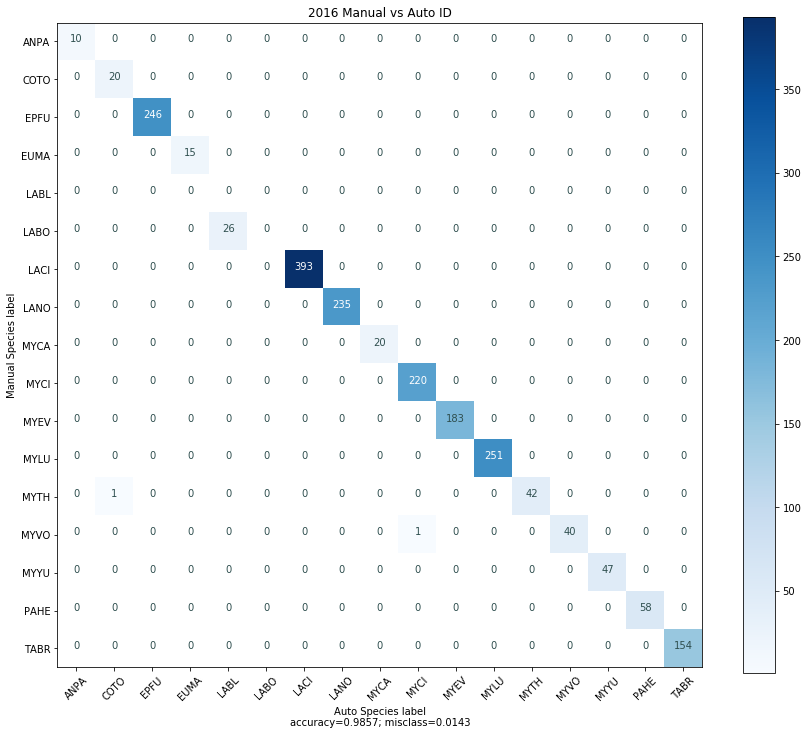

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(confirmed.Species_Manual_ID, confirmed.Species_Auto_ID)

target_names = np.unique(confirmed[['Species_Manual_ID', 'Species_Auto_ID']].values)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, target_names=target_names, normalize=False, title='2016 Manual vs Auto ID')


## Now let's convert this dataframe to the formats needed for this NABat occupancy analysis

#### Add in columns for cell, site, filedatetime, and monitoring night based on the file names.

### Table 1.  Sonobat auto ID output

In [13]:
df.head()

,#Accpt,#Maj,1st,2nd,3rd,4th,<--AllsppinsqncclassifiedwithaDP>0.75inorderofprevalence,AccpQualForTally,AccpQuality,ByVote,...,ParentDir,path,Preemphasis,SiteID,Species_Auto_ID,Species_Manual_ID,Version,calls/sec,filedatetime,monitoringnight
0,1.0,1.0,Epfu,NaN,NaN,NaN,NaN,0.2,0.8,NaN,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,NAN,NAN,3.15,7.42,2016-07-22 20:50:30,2016-07-22
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.8,NaN,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,NAN,NAN,3.15,1.79,2016-07-22 21:25:03,2016-07-22
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.8,NaN,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,NAN,NAN,3.15,1.28,2016-07-22 21:25:49,2016-07-22
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.8,NaN,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,NAN,NAN,3.15,2.41,2016-07-22 21:37:04,2016-07-22
4,5.0,5.0,Lano,NaN,NaN,NaN,NaN,0.2,0.8,Lano,...,1005NE,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,medium,NE,LANO,LANO,3.15,2.16,2016-07-22 21:42:12,2016-07-22


In [ ]:
auto = df.groupby(['GridCellID', 'SiteID', 'monitoringnight'])['Species_Auto_ID'].value_counts()
auto  = auto.reset_index(name='Species_Auto_ID_count', level=-1)
auto.Species_Auto_ID = auto.Species_Auto_ID.replace('', '_blank')
auto_id_counts = auto.pivot(columns='Species_Auto_ID').replace(np.nan, '0')
auto_id_counts.to_csv(out_dir.joinpath("CNHP_AutoIDResults_2016.csv"))
auto_id_counts

### Table 2 Sonobat auto id output joined to manually vetted classifications (Truth)

In [15]:
vetted = df[~df.Species_Manual_ID.isin(['NOT VETTED', 'UNCONFIRMED', 'NOISE', 'UNIDENTIFIED', 'YES', 'HIF', 'LOF', 'NOID', 'NAN'])].dropna(subset=['Species_Manual_ID'])
vetted = vetted[~vetted.Species_Auto_ID.isin(['HIF', 'LOF', 'NOID', 'NAN'])].dropna(subset=['Species_Auto_ID'])

In [ ]:
auto_ = vetted.groupby(['GridCellID', 'SiteID', 'monitoringnight', 'Species_Manual_ID'])['Species_Auto_ID'].value_counts()
auto_  = auto_.reset_index(name='Species_Auto_ID_count', level=-1)
auto_.Species_Auto_ID = auto_.Species_Auto_ID.replace('', '_blank')
auto_id_counts_ = auto_.pivot(columns='Species_Auto_ID').replace(np.nan, '0')

manual = vetted.groupby(['GridCellID', 'SiteID', 'monitoringnight'])['Species_Manual_ID'].value_counts()
manual  = manual.reset_index(name='Species_Manual_ID_count', level=-1)
manual.Species_Manual_ID = manual.Species_Manual_ID.replace('', '_blank')

manual = manual.set_index(['Species_Manual_ID'], append=True)
manual
table2 = pd.concat([manual, auto_id_counts_], axis=1)
table2.to_csv(out_dir.joinpath("CNHP_ManualIDResults_2016.csv"))
table2

In [17]:
df[['GridCellID', 'SiteID', 'filedatetime', 'monitoringnight']].to_csv(out_dir.joinpath("2016_survey_nights.csv"), index=False)

# Save these out to the NABat bulk upload template

In [18]:
site_md_fname = r"F:\CO_NABat\CO NABAT 2016 Bulk_Stationary_Acoustic_Template.csv"
site_md = pd.read_csv(site_md_fname, skiprows=[1], index_col=['Grts Id', 'Location Name'])
site_md.head()

UTME     UTMN First Monitoring Night  \
Grts Id Location Name                                           
2       NW             170440  4355996              6/30/2016   
        SW             174304  4354564              6/30/2016   
        NE             176892  4360344              6/30/2016   
        SE             178373  4353544              6/30/2016   
61      NE             548408  4211808              7/11/2016   

                      Fourth Monitoring Night                       Detector  \
Grts Id Location Name                                                          
2       NW                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        SW                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        NE                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        SE                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
61      NE                          7/14/2016  WILDLIFE ACOUSTICS SM2Bat-192   

                                      Microphone  Microphone Orientation  \
Grts Id Location Name                                                      
2       NW             Wildlife Acoustics SMX-US                     NaN   
        SW             Wildlife Acoustics SMX-US                     NaN   
        NE             Wildlife Acoustics SMX-US                     NaN   
        SE             Wildlife Acoustics SMX-US                     NaN   
61      NE             Wildlife Acoustics SMX-US                     NaN   

                       Microphone Height (meters)  \
Grts Id Location Name                               
2       NW                                    2.0   
        SW                                    2.0   
        NE                                    2.0   
        SE                                    2.0   
61      NE                                    3.0   

                       Distance to Nearest Clutter (meters) Clutter Type  \
Grts Id Location Name                                                      
2       NW                                              NaN   vegetation   
        SW                                              NaN   vegetation   
        NE                                              NaN   vegetation   
        SE                                              NaN   vegetation   
61      NE                                              NaN   vegetation   

                       Distance to Nearest Water (meters)  Water Type  \
Grts Id Location Name                                                   
2       NW                                            NaN         NaN   
        SW                                            NaN         NaN   
        NE                                            NaN         NaN   
        SE                                            NaN         NaN   
61      NE                                            NaN         NaN   

                       Percent Clutter Broad Habitat Type  \
Grts Id Location Name                                       
2       NW                         NaN          shrubland   
        SW                         NaN          shrubland   
        NE                         NaN          shrubland   
        SE                         NaN          shrubland   
61      NE                         NaN            prairie   

                      Audio Recording Name (*.wav *.zc) Software Type  
Grts Id Location Name                                                  
2       NW                                           FS   Sonobat 3.x  
        SW                                           FS   Sonobat 3.x  
        NE                                           FS   Sonobat 3.x  
        SE                                           FS   Sonobat 3.x  
61      NE                                           FS   Sonobat 3.x

In [19]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:26912')
outProj = Proj(init='epsg:4326')

def from_utm(row):
    

    x1,y1 = row['UTME'], row['UTMN']
    x2,y2 = transform(inProj,outProj,x1,y1)
    return (x2,y2)

site_md['long'], site_md['lat'] = zip(*site_md.apply(from_utm, axis=1))

In [20]:
site_md.head()

UTME     UTMN First Monitoring Night  \
Grts Id Location Name                                           
2       NW             170440  4355996              6/30/2016   
        SW             174304  4354564              6/30/2016   
        NE             176892  4360344              6/30/2016   
        SE             178373  4353544              6/30/2016   
61      NE             548408  4211808              7/11/2016   

                      Fourth Monitoring Night                       Detector  \
Grts Id Location Name                                                          
2       NW                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        SW                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        NE                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
        SE                           7/3/2016     WILDLIFE ACOUSTICS SM2Bat+   
61      NE                          7/14/2016  WILDLIFE ACOUSTICS SM2Bat-192   

                                      Microphone  Microphone Orientation  \
Grts Id Location Name                                                      
2       NW             Wildlife Acoustics SMX-US                     NaN   
        SW             Wildlife Acoustics SMX-US                     NaN   
        NE             Wildlife Acoustics SMX-US                     NaN   
        SE             Wildlife Acoustics SMX-US                     NaN   
61      NE             Wildlife Acoustics SMX-US                     NaN   

                       Microphone Height (meters)  \
Grts Id Location Name                               
2       NW                                    2.0   
        SW                                    2.0   
        NE                                    2.0   
        SE                                    2.0   
61      NE                                    3.0   

                       Distance to Nearest Clutter (meters) Clutter Type  \
Grts Id Location Name                                                      
2       NW                                              NaN   vegetation   
        SW                                              NaN   vegetation   
        NE                                              NaN   vegetation   
        SE                                              NaN   vegetation   
61      NE                                              NaN   vegetation   

                       Distance to Nearest Water (meters)  Water Type  \
Grts Id Location Name                                                   
2       NW                                            NaN         NaN   
        SW                                            NaN         NaN   
        NE                                            NaN         NaN   
        SE                                            NaN         NaN   
61      NE                                            NaN         NaN   

                       Percent Clutter Broad Habitat Type  \
Grts Id Location Name                                       
2       NW                         NaN          shrubland   
        SW                         NaN          shrubland   
        NE                         NaN          shrubland   
        SE                         NaN          shrubland   
61      NE                         NaN            prairie   

                      Audio Recording Name (*.wav *.zc) Software Type  \
Grts Id Location Name                                                   
2       NW                                           FS   Sonobat 3.x   
        SW                                           FS   Sonobat 3.x   
        NE                                           FS   Sonobat 3.x   
        SE                                           FS   Sonobat 3.x   
61      NE                                           FS   Sonobat 3.x   

                             long        lat  
Grts Id Location Name                         
2       NW            -1

In [21]:
import nabatpy
colorado = nabatpy.get_grts_data(grid_frame='Conus', state="Colorado")

colorado = colorado.set_index('GRTS_ID', drop=False)
colorado.head()

,CONUS_10KM,GRTS_ID,cnty_n_1,cnty_n_2,cnty_n_3,cnty_n_4,cnty_n_5,cnty_p_1,cnty_p_2,cnty_p_3,...,own_USFS,state_n_1,state_n_2,state_n_3,state_n_4,state_p_1,state_p_2,state_p_3,state_p_4,water_p
GRTS_ID,,,,,,,,,,,,,,,,,,,,,
2,74208,2,Colorado_Mesa,NA,NA,NA,NA,100.000000,0.000000,0.00000,...,0.000000,Colorado,NA,NA,NA,100.000000,0.000000,0.00000,0.0,0.034166
61,65909,61,Colorado_Pueblo,NA,NA,NA,NA,100.000000,0.000000,0.00000,...,0.000000,Colorado,NA,NA,NA,100.000000,0.000000,0.00000,0.0,0.019721
82,78428,82,Colorado_Phillips,Colorado_Logan,NA,NA,NA,60.630693,39.369307,0.00000,...,0.000000,Colorado,NA,NA,NA,100.000000,0.000000,0.00000,0.0,0.008068
114,59911,114,Kansas_Morton,Colorado_Baca,Oklahoma_Texas,Oklahoma_Cimarron,NA,85.021658,8.437391,4.90595,...,62.324001,Kansas,Colorado,Oklahoma,NA,85.021658,8.437391,6.54095,0.0,0.004496
125,61749,125,Colorado_Las Animas,NA,NA,NA,NA,100.000000,0.000000,0.00000,...,1.756847,Colorado,NA,NA,NA,100.000000,0.000000,0.00000,0.0,0.000000


In [22]:
autoid_by_grts = auto_id_counts.astype(int).groupby(level=[0]).sum()

if autoid_by_grts.index[0] == '':
    autoid_by_grts = autoid_by_grts.iloc[1:, :]

flat_cols = list(autoid_by_grts.columns.get_level_values(1))
# flat_cols = ['GridCellID'] + flat_cols[1:]
autoid_by_grts.columns = flat_cols
flat_cols.pop(flat_cols.index('NAN'))
flat_cols.append('NAN')
autoid_by_grts = autoid_by_grts[flat_cols].reset_index()
# autoid_by_grts = autoid_by_grts.reindex(df.GridCellID)
# autoid_by_grts = autoid_by_grts.sort_index()
autoid_by_grts['GridCellID'] = autoid_by_grts.GridCellID.astype(int)
autoid_by_grts.dtypes

GridCellID    int32
ANPA          int32
COTO          int32
EPFU          int32
EUMA          int32
LABL          int32
LACI          int32
LANO          int32
MYCA          int32
MYCI          int32
MYEV          int32
MYLU          int32
MYTH          int32
MYVO          int32
MYYU          int32
PAHE          int32
TABR          int32
NAN           int32
dtype: object

In [23]:
colorado_auto = colorado.merge(autoid_by_grts, how='right', left_on='GRTS_ID', right_on='GridCellID')
colorado_auto.head()

C:\Anaconda3\envs\pyviz\lib\site-packages\geopandas\geodataframe.py:475: FutureWarning: 'GRTS_ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  result = DataFrame.merge(self, *args, **kwargs)


,CONUS_10KM,GRTS_ID,cnty_n_1,cnty_n_2,cnty_n_3,cnty_n_4,cnty_n_5,cnty_p_1,cnty_p_2,cnty_p_3,...,MYCA,MYCI,MYEV,MYLU,MYTH,MYVO,MYYU,PAHE,TABR,NAN
0,74208,2,Colorado_Mesa,NA,NA,NA,NA,100.000000,0.000000,0.000000,...,1,15,1,4,2,1,2,155,239,2548
1,65909,61,Colorado_Pueblo,NA,NA,NA,NA,100.000000,0.000000,0.000000,...,6,13,2,2,0,0,34,5,14,189
2,66801,157,Colorado_Dolores,Colorado_San Miguel,NA,NA,NA,54.128191,45.871809,0.000000,...,0,86,66,2761,0,12,0,0,194,5226
3,65406,221,Utah_San Juan,Colorado_Dolores,Colorado_Montezuma,NA,NA,53.035965,40.166830,6.797205,...,1,49,12,21,0,0,1,14,9,427
4,77954,253,Colorado_Morgan,NA,NA,NA,NA,100.000000,0.000000,0.000000,...,0,64,5,3,0,0,0,0,40,989


In [24]:
import geopandas as gpd
counties = gpd.read_file(r"Y:\AdministrativeBoundaries\National\CountyBoundaries.shp")

In [25]:
colo_point = colorado_auto.copy()
colo_point['geometry'] = colo_point.geometry.centroid

ANPA
COTO
EPFU
EUMA
LABL
LACI
LANO
MYCA
MYCI
MYEV
MYLU
MYTH
MYVO
MYYU
PAHE
TABR


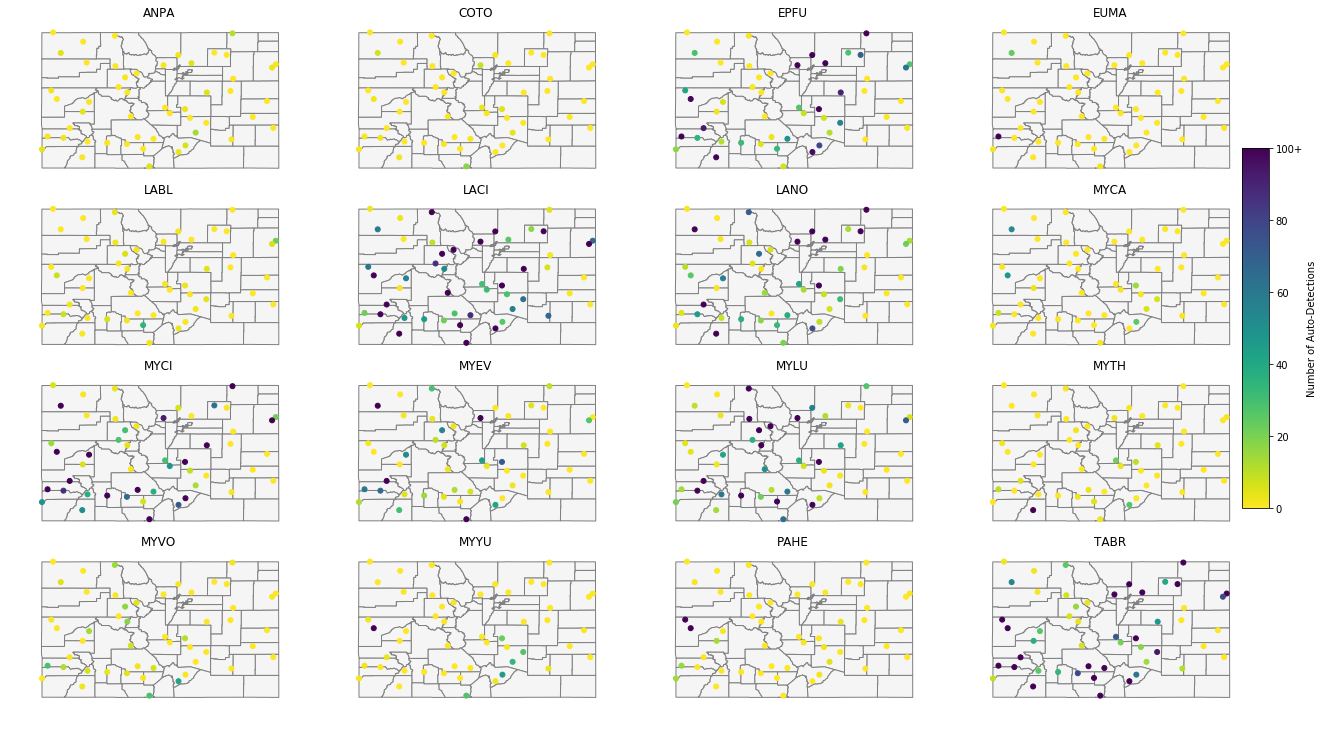

In [26]:
f, ax = plt.subplots(4, 4, figsize=(25, 10))

vmin = 0
vmax = 100

for i, species in enumerate(colorado_auto.columns[-17:-1]):
    print(species)
    counties[counties.STATE=='CO'].plot(ax=ax.flatten()[i], color='whitesmoke', edgecolor='grey')
    colo_point.plot(column=species, 
                     legend=False, 
                     cmap=plt.cm.viridis_r, 
                     ax=ax.flatten()[i],
                     vmin=vmin, vmax=vmax,
                     markersize=25)
    ax.flatten()[i].set_title(species)
    ax.flatten()[i].set_axis_off()
    
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis_r, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
f.subplots_adjust(bottom=0.01, right=0.8, top=0.99, hspace=0)
cbar_ax = f.add_axes([0.8, 0.3, 0.015, 0.5])
cbar = f.colorbar(sm, cax=cbar_ax)

cbar.set_label("Number of Auto-Detections")

ticks = cbar.ax.get_yticklabels()
ticks[-1] = f"{vmax}+"
f.suptitle = "CNHP 2016 Autodetection Results"
cbar.ax.set_yticklabels(ticks);

ANPA
COTO
EPFU
EUMA
LABL
LACI
LANO
MYCA
MYCI
MYEV
MYLU
MYTH
MYVO
MYYU
PAHE
TABR


Text(0.5,0.98,'CNHP 2016 Auto-detections')

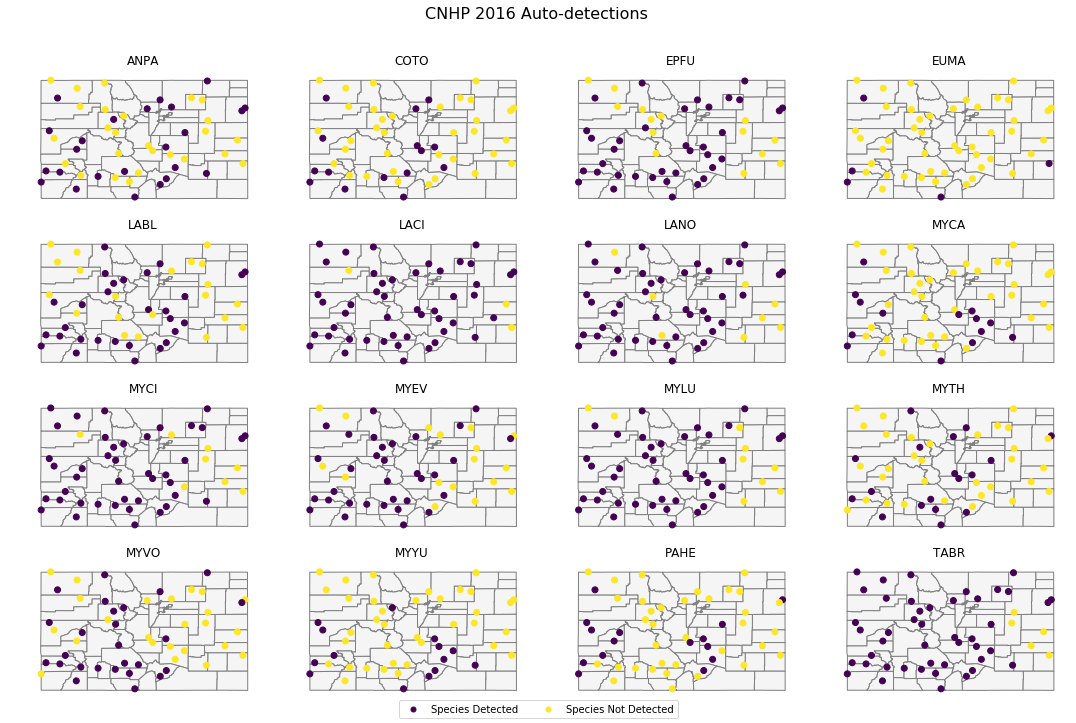

In [27]:
fig, ax = plt.subplots(4, 4, figsize=(15, 10))


vmin = 0
vmax = 100



for i, species in enumerate(colorado_auto.drop('NAN', axis=1).columns[-16:]):
    if species != 'NAN':
        print(species)
        counties[counties.STATE=='CO'].plot(ax=ax.flatten()[i], color='whitesmoke', edgecolor='grey')
        
        species_data = colo_point[[species, 'geometry']].fillna(0)
        species_data['present'] = species_data[species]>0
        result = species_data.plot(categorical=True, column='present', cmap=plt.cm.viridis_r, ax=ax.flatten()[i])
        
        ax.flatten()[i].set_title(species)
        ax.flatten()[i].set_axis_off()
    
import matplotlib.lines as mlines
pres = mlines.Line2D([], [], color=plt.cm.viridis_r(1.0), marker='.', linestyle='None',
                          markersize=10, label='Species Detected')
absent = mlines.Line2D([], [], color=plt.cm.viridis_r(0.0), marker='.', linestyle='None',
                          markersize=10, label='Species Not Detected')

plt.figlegend(handles=[pres, absent], loc='lower center', ncol=2)

plt.tight_layout()

fig.subplots_adjust(bottom=0.01, right=0.99, top=0.9, hspace=0.1, )
fig.suptitle('CNHP 2016 Auto-detections', fontsize=16)

In [28]:
df[['GridCellID', 'SiteID', 'monitoringnight', 'filedatetime', 
    'path', 'filename',
    'Species_Auto_ID', 'Species_Manual_ID',
    '#Accpt', '#Maj', '1st', '2nd', '3rd', '4th',
    '<--AllsppinsqncclassifiedwithaDP>0.75inorderofprevalence',
    'AccpQualForTally', 'AccpQuality', 'ByVote', 'Clssnif<Thr', 'DPThr',
    'DPif<Thr', 'DiscrProb', 'DurStdDev', 'Durmean', 'FcStdDev', 'Fcmean',
    'FileLngth',  'Filter',  'HiFspp', 'LoFspp',
    'Max#CallsConsidered', 'MaxSegLngth', 'MeanClssn', 'NextDirUp',
    'Preemphasis', 
    'Version', 'calls/sec']]

,GridCellID,SiteID,monitoringnight,filedatetime,path,filename,Species_Auto_ID,Species_Manual_ID,#Accpt,#Maj,...,Filter,HiFspp,LoFspp,Max#CallsConsidered,MaxSegLngth,MeanClssn,NextDirUp,Preemphasis,Version,calls/sec
0,1005,NE,2016-07-22,2016-07-22 20:50:30,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_205030.wav,NAN,NAN,1.0,1.0,...,5 kHz,NaN,1,8,8.0 sec,Epfu,1005,medium,3.15,7.42
1,1005,NE,2016-07-22,2016-07-22 21:25:03,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_212503.wav,NAN,NAN,NaN,NaN,...,5 kHz,NaN,NaN,8,8.0 sec,NaN,1005,medium,3.15,1.79
2,1005,NE,2016-07-22,2016-07-22 21:25:49,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_212549.wav,NAN,NAN,NaN,NaN,...,5 kHz,NaN,1,8,8.0 sec,NaN,1005,medium,3.15,1.28
3,1005,NE,2016-07-22,2016-07-22 21:37:04,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_213704.wav,NAN,NAN,NaN,NaN,...,5 kHz,NaN,1,8,8.0 sec,NaN,1005,medium,3.15,2.41
4,1005,NE,2016-07-22,2016-07-22 21:42:12,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_214212.wav,LANO,LANO,5.0,5.0,...,5 kHz,NaN,1,8,8.0 sec,Lano,1005,medium,3.15,2.16
5,1005,NE,2016-07-22,2016-07-22 21:45:14,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_214514.wav,LANO,NAN,4.0,4.0,...,5 kHz,NaN,1,8,8.0 sec,Lano,1005,medium,3.15,2.52
6,1005,NE,2016-07-22,2016-07-22 21:45:28,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_214528.wav,NAN,NAN,NaN,NaN,...,5 kHz,NaN,NaN,8,8.0 sec,NaN,1005,medium,3.15,1.28
7,1005,NE,2016-07-22,2016-07-22 21:47:13,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_214713.wav,MYCI,MYCI,3.0,3.0,...,5 kHz,1.0,NaN,8,8.0 sec,Myci,1005,medium,3.15,8.41
8,1005,NE,2016-07-22,2016-07-22 21:52:03,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_215203.wav,TABR,TABR,2.0,2.0,...,5 kHz,NaN,1,8,8.0 sec,Tabr,1005,medium,3.15,1.91
9,1005,NE,2016-07-22,2016-07-22 21:58:02,P:\Bat_CPW\NABat\2016\acoustic\1005\1005NE\NAB...,NABAT1005-NE_20160722_215802.wav,TABR,NAN,1.0,1.0,...,5 kHz,NaN,1,8,8.0 sec,Tabr,1005,medium,3.15,1.41
